In [1]:
import pandas as pd
import numpy as np
import os
import re
from shutil import copyfile
import json
import sys
import subprocess
import scipy.io as sio
import itertools

from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def half_integer_round(number):
    return round(number * 2) / 2


def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [3]:
# project_filepath = "/data/behavioraldata/scanfiles/"

# project_file_contents = os.listdir(project_filepath)

# project_file_contents_mat = [item for item in project_file_contents if ".mat" in item]
# project_file_contents_mat = [item for item in project_file_contents_mat if "video" in item]


# for file in project_file_contents_mat:
#     mat_contents = sio.loadmat(project_filepath + file)
#     csv_contents = pd.DataFrame(mat_contents['allRatings'])
#     csv_contents.columns = ['time', 'rating']
#     csv_title = str.split(file, "/")[0]
#     csv_title = str.replace(csv_title, ".mat", ".csv")
    
#     csv_contents.to_csv(project_filepath + csv_title, index=False)
    

In [4]:
project_filepath = "/data/behavioraldata/scanfiles/"

project_file_contents = os.listdir(project_filepath)

project_file_contents_mat = [item for item in project_file_contents if ".mat" in item]


#Get unique subject IDs (first three numbers of filename)
unique_sub_ids = [item for item in project_file_contents if 'video' in item]
unique_sub_ids = set([str.split(file, "_")[0] for file in unique_sub_ids])



In [5]:
#Load and Concatenate all ref files

def create_ref_file(sub_id, project_file_contents):
    ref_file_contents = [item for item in project_file_contents_mat if "intfMRI" + str(sub_id) in item]
    ref_file_data = []
    for file in ref_file_contents: 
        mat_contents = sio.loadmat(project_filepath + file)
        ref_file_data.append(pd.DataFrame(mat_contents['data']))
    
    #Join all files and remove empty data and irrelevant columns
    ref_file_data = pd.concat(ref_file_data)
    ref_file_data = ref_file_data[ref_file_data[5] != 0]
    ref_file_data = ref_file_data[ref_file_data[6] != 0]
    ref_file_data = ref_file_data.loc[:,0:4]
    
    ref_file_data.columns = ["sub_id", "trial", "video_number", "self_other", "neg_pos"]
    
    #Remove duplicate trials
    ref_file_data = ref_file_data.drop_duplicates("trial")
    
    #Recode neg pos and self_other
    ref_file_data['self_other'][ref_file_data['self_other'] == 1] = "self"
    ref_file_data['self_other'][ref_file_data['self_other'] == 2] = "other"
    ref_file_data['neg_pos'][ref_file_data['neg_pos'] == 1] = "neg"
    ref_file_data['neg_pos'][ref_file_data['neg_pos'] == 2] = "pos"
    
    return ref_file_data


In [6]:
# for subject id in unique subids, get all videos
# loop through videos
# append to data frame with all videos
def get_video_data(sub_id, video):
    project_file_contents = os.listdir(project_filepath)
    project_file_contents = [item for item in project_file_contents if ".csv" in item]
    sub_video_filenames = [item for item in project_file_contents if str(sub_id)  in item]
    sub_video_filenames = [item for item in sub_video_filenames if 'video'  in item]
    sub_video_data = []

    for file in sub_video_filenames: 
        #mat_contents = sio.loadmat(project_filepath + file)
        #video_data = pd.DataFrame(mat_contents['allRatings'])
        mat_contents = pd.read_csv(project_filepath + file)
        video_data = pd.DataFrame(mat_contents)
        video_data.columns = ['second', 'rating']
        video_data['subject'] = str.split(file, "_")[0]
        video_data['video_number'] = int(float(str.split(file, "_")[2].replace('.csv', '').replace('video', '')))
        video_data['second'] = video_data['second'].apply(lambda x: half_integer_round(x))
        sub_video_data.append(video_data)


    sub_video_data = pd.concat(sub_video_data)
    ref_data = create_ref_file(sub_id, project_file_contents)
    all_videos = pd.merge(sub_video_data, ref_data, on='video_number', how='left')
    video_data = all_videos[all_videos['video_number'] == video]
    video_data = video_data[video_data['second'] != 0]

    return(video_data[['second','rating']])
    


In [15]:
unique_sub_ids = ['229', '223', '146', '242', '179', '186', '138', '145', '157', '161', '163', '214', '236', '245', '288',  '231', '196', '184', '220', '239', '195', '282', '177', '266', '160', '197', '208', '173', '216', '156', '200', '256', '167', '222', '279', '237', '263', '168', '280', '147', '165', '277', '278', '253', '188', '289', '162', '262', '276', '267', '139', '219', '260', '215', '257', '999', '154', '251', '274', '270']
#unique_sub_ids.sort(key=float)
print(unique_sub_ids)

['229', '223', '146', '242', '179', '186', '138', '145', '157', '161', '163', '214', '236', '245', '288', '231', '196', '184', '220', '239', '195', '282', '177', '266', '160', '197', '208', '173', '216', '156', '200', '256', '167', '222', '279', '237', '263', '168', '280', '147', '165', '277', '278', '253', '188', '289', '162', '262', '276', '267', '139', '219', '260', '215', '257', '999', '154', '251', '274', '270']


In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
#Plots correlations heatmap matrix

def plot_corrs(all_video_data, video):
    
    sns.set(style="white")

    # Compute the correlation matrix
    all_video_data = all_video_data.drop('second', 1) #Drop seconds for correlation
    corr = all_video_data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,  cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    averge_z_correlation = calculate_aver_correlation(all_video_data)

    plt.title('Video: ' + str(video) + " , average z correlation: " + str(averge_z_correlation))



In [10]:
#Calculate average calculation

def calculate_aver_correlation(all_video_data): 
    unique_sub_ids = list(all_video_data)
    combinations = pd.DataFrame(list(itertools.combinations(unique_sub_ids, 2)))
    corr = all_video_data.corr()

    df = []
    for index, row in combinations.iterrows():
        df.append([row[0], row[1], corr[row[0]][row[1]]])


    df = pd.DataFrame(df)
    df.columns = ['sub1', 'sub2', 'corr']

    df['z'] = 0.5*np.log((1+df['corr'])/(1-df['corr']))
    df['z'] = pd.to_numeric(df['z'], errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan)
    return(df['z'].mean())



In [13]:
plt.close('all')

/opt/conda/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


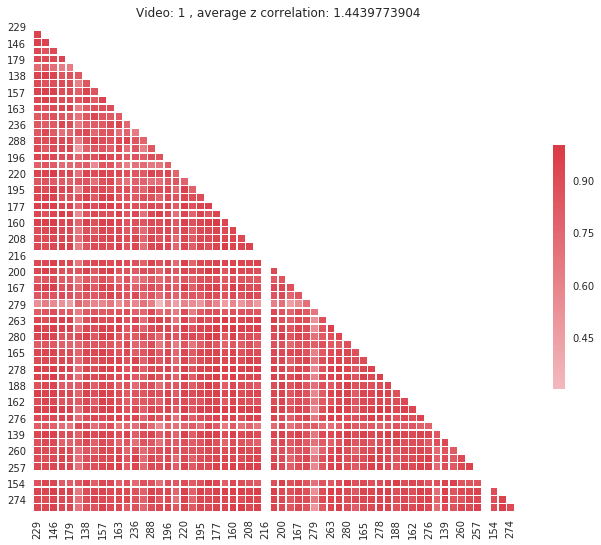

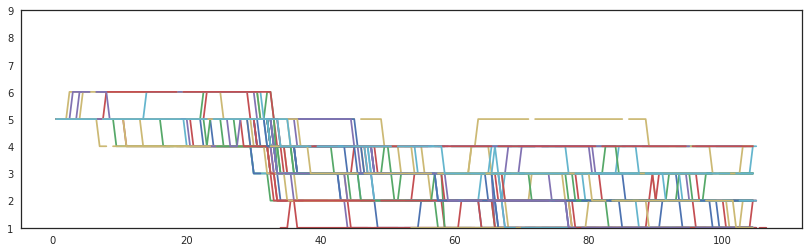

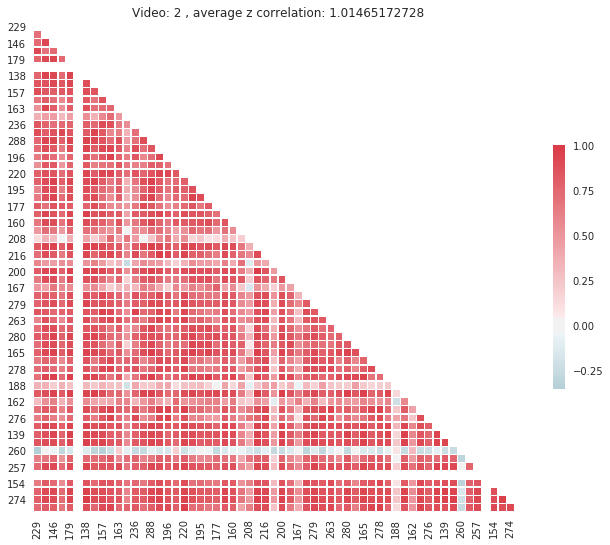

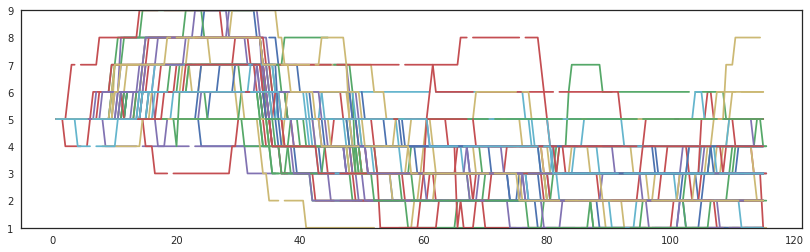

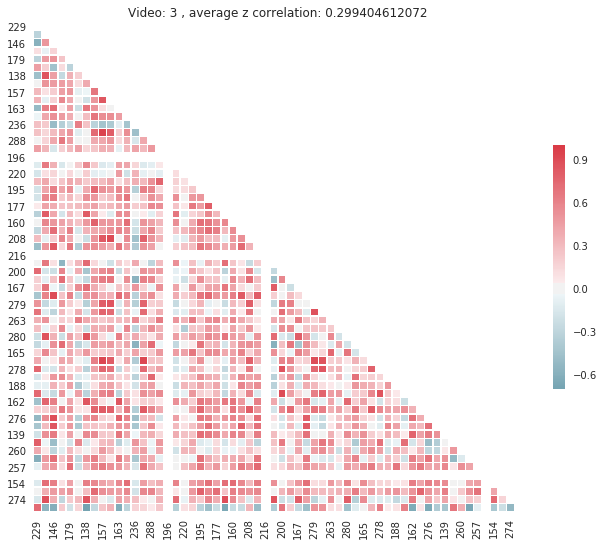

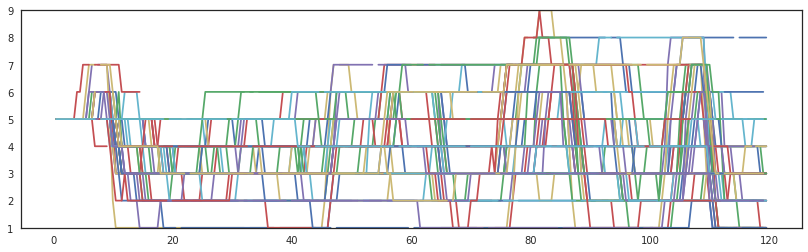

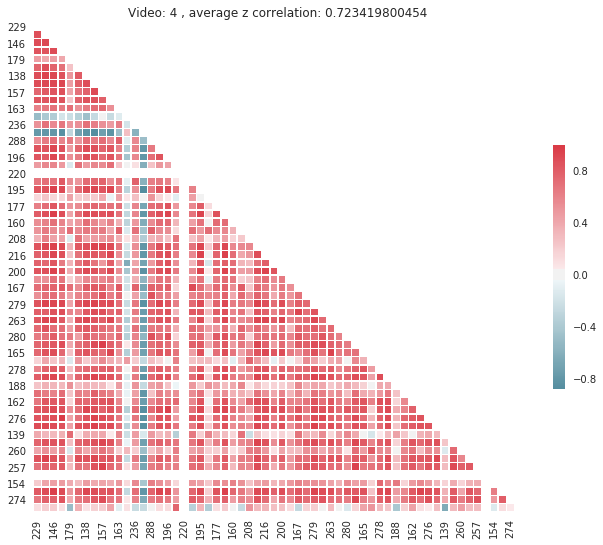

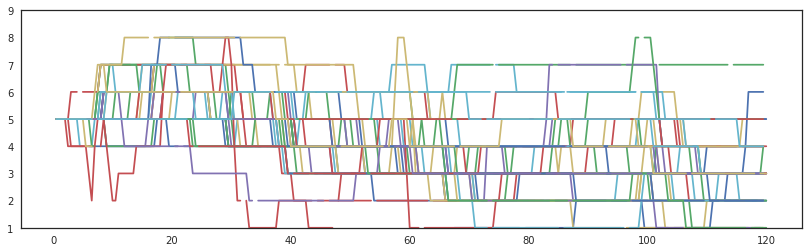

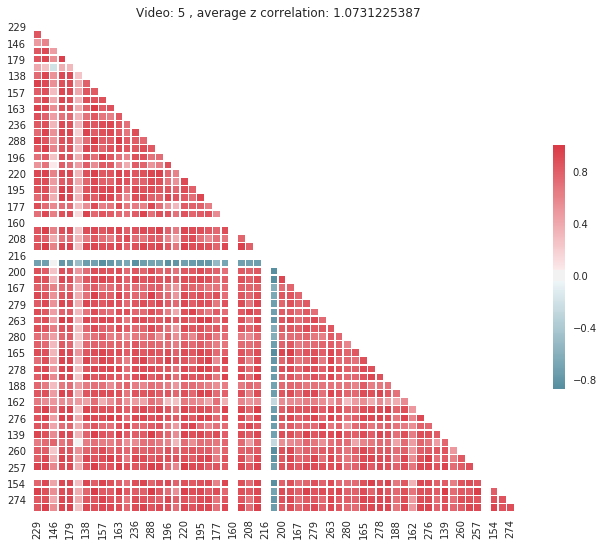

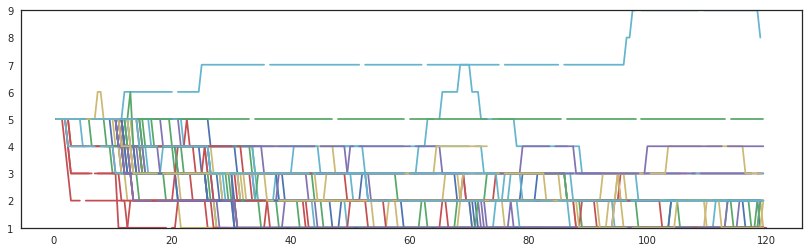

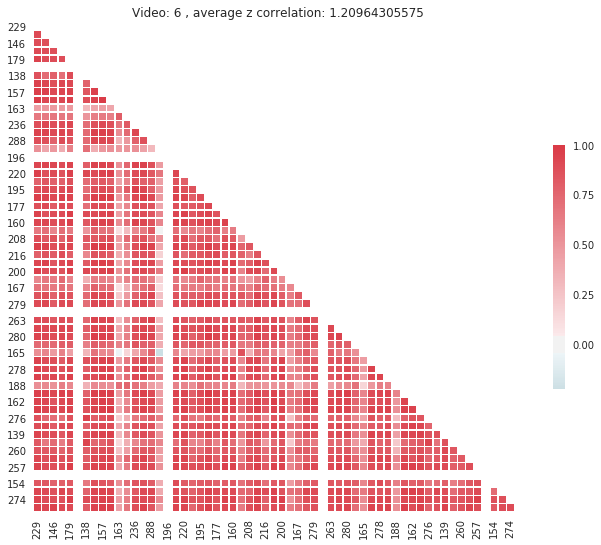

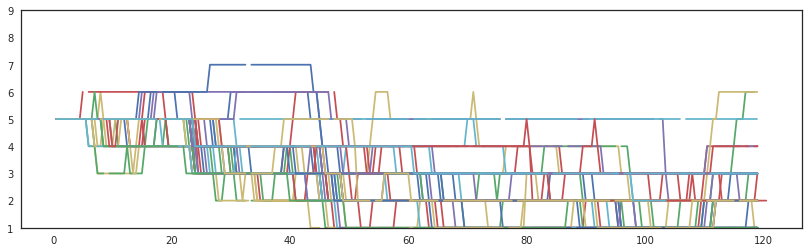

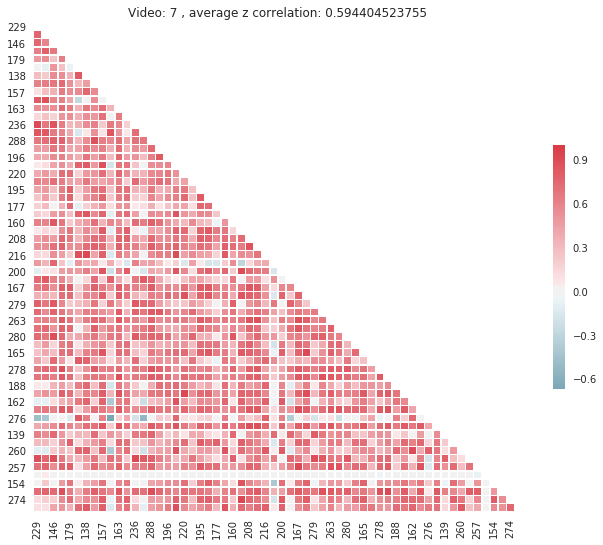

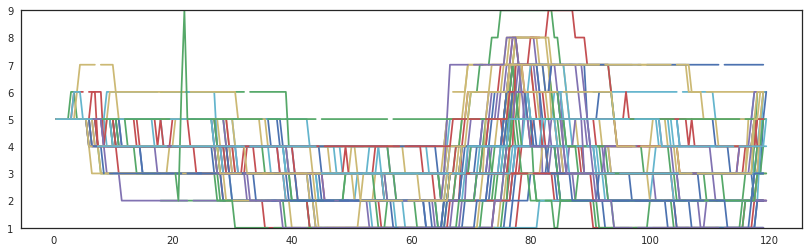

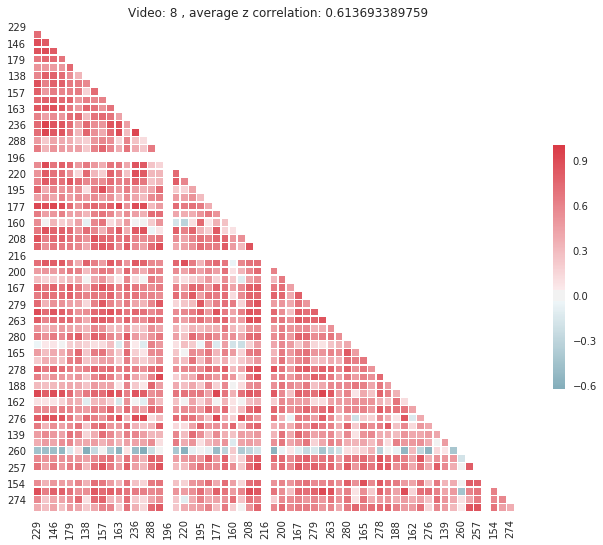

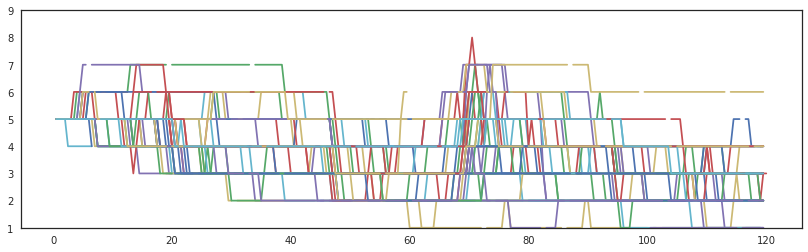

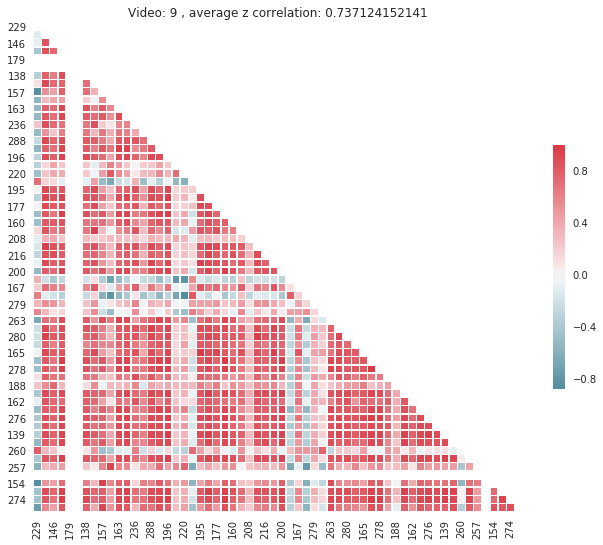

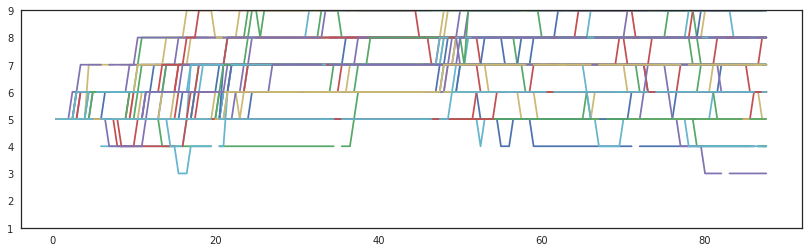

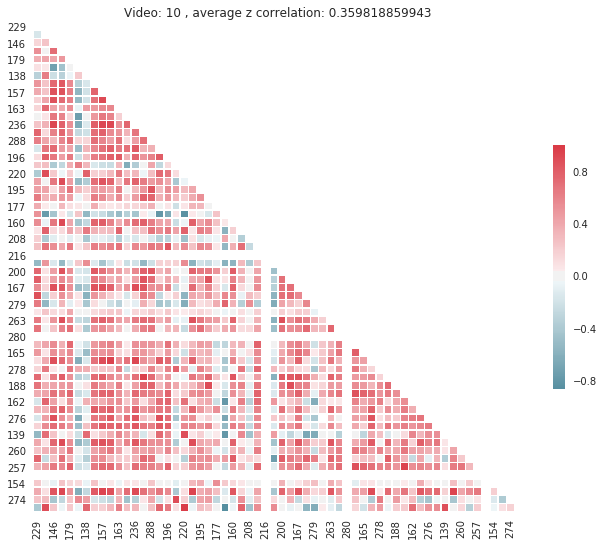

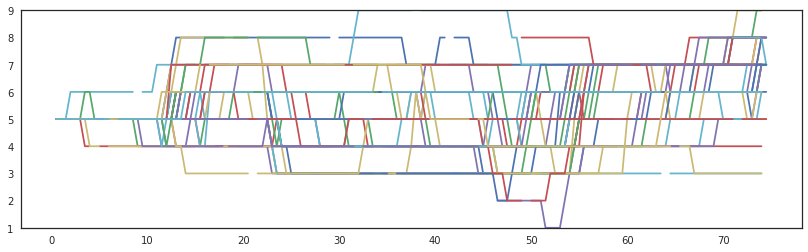

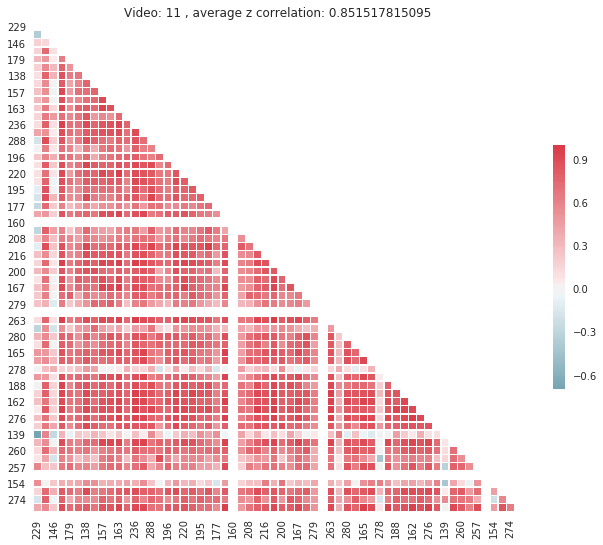

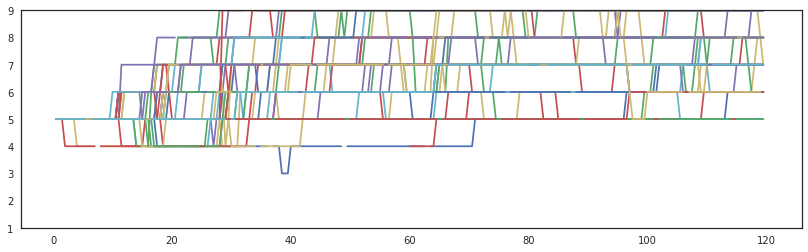

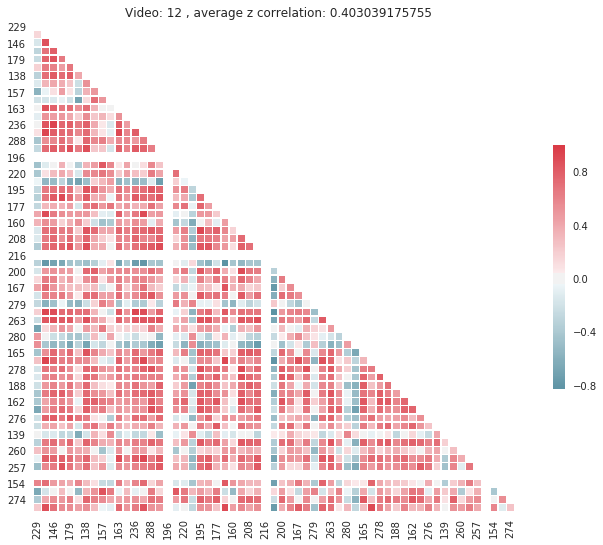

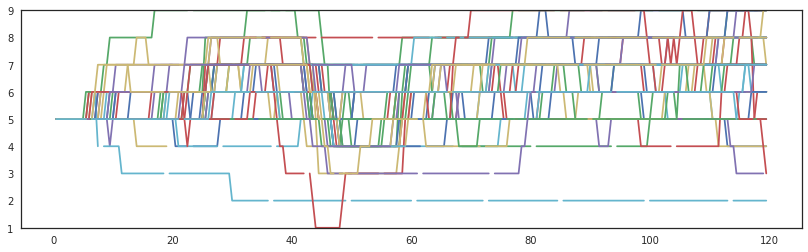

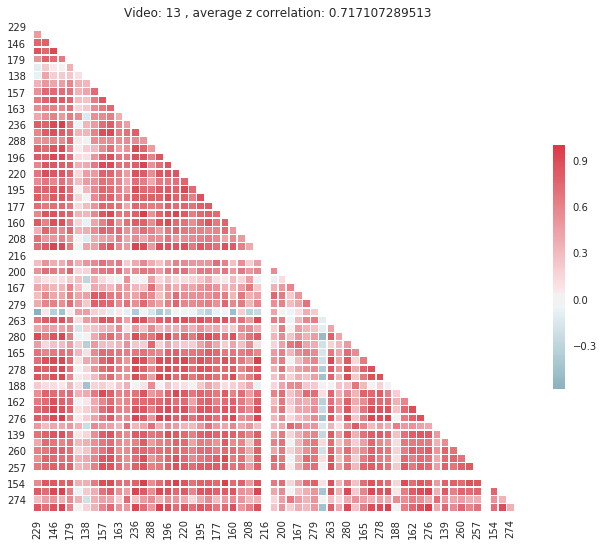

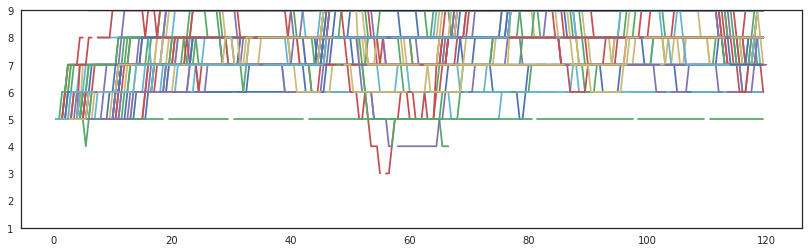

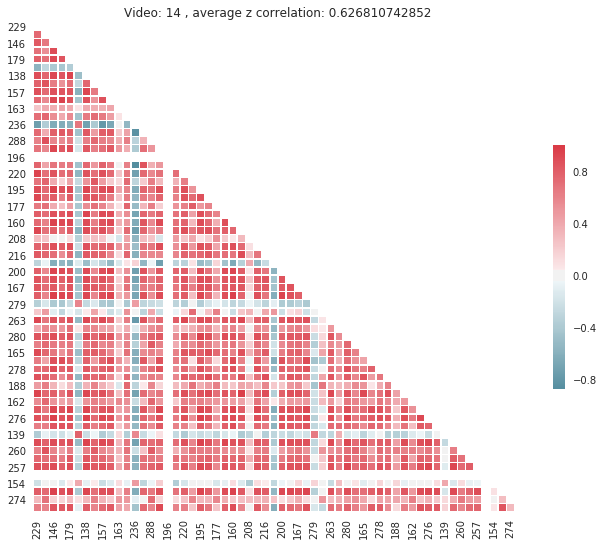

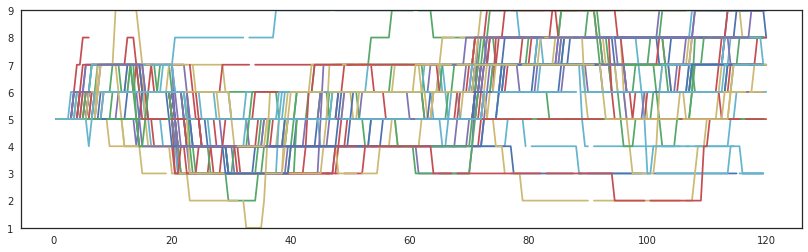

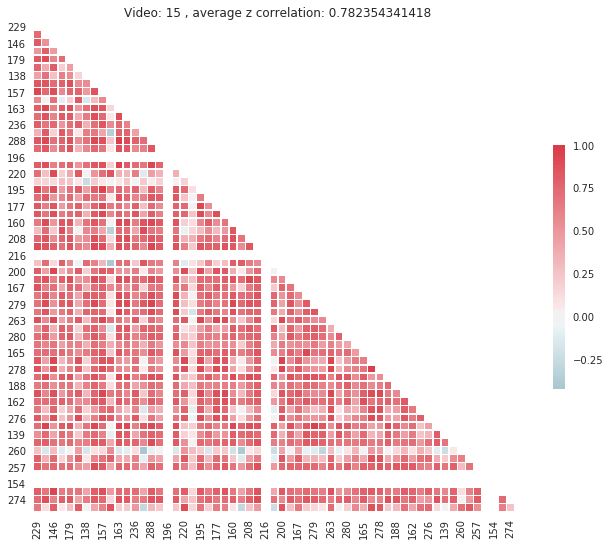

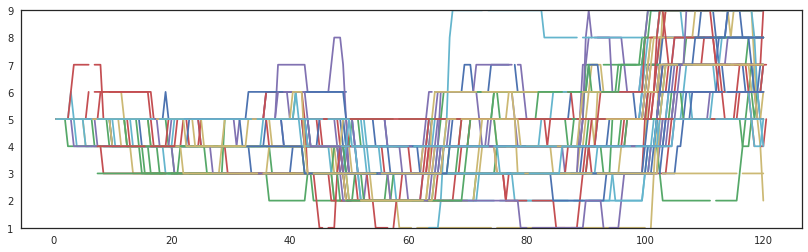

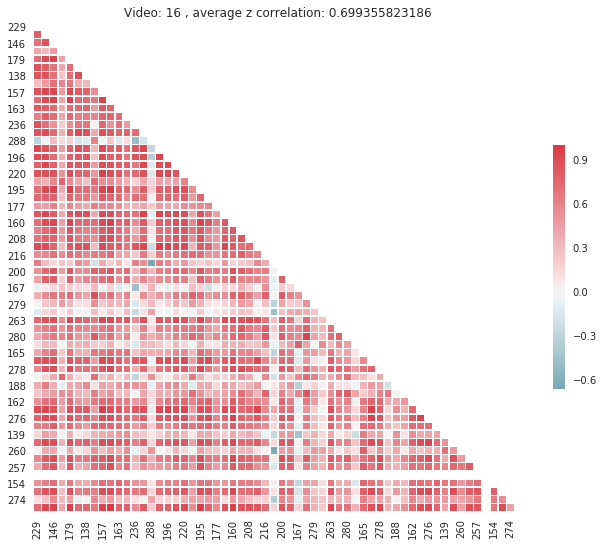

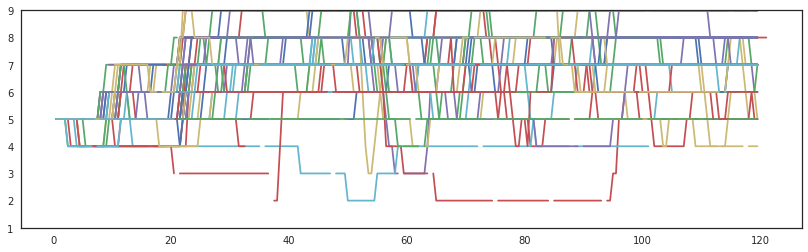

In [32]:
##Calculate everything for all subject data

z_correlations = []
for video in range(1, 17): 
    
    
    #Get video length and make array of each half second
    video_length = get_video_data(unique_sub_ids[0], video)['second'].max()
    all_video_data = pd.DataFrame({'second': list(frange(0, video_length, 0.5))})
    
    #Compile all subjects
    for sub_id in unique_sub_ids: 
        subject_data = get_video_data(sub_id, video)
        
        #Added to map changes
        subject_data = subject_data.rename(columns ={'rating': sub_id})
        all_video_data = pd.merge(all_video_data, subject_data , on='second', how='outer')
        all_video_data = all_video_data[all_video_data['second'] != 0] #Remove data after scan is over
        #all_video_data = all_video_data.fillna(method='pad', limit =1) #fill forward for any NAs, shouldn't be a problem for correlations
        
    #Clean data and chang e100 to "target"
    #all_video_data = all_video_data.dropna(axis=1, thresh=10) #If more than 10 time points are NA, drop
    #all_video_data = all_video_data.rename(columns = {'100': 'target'})
    
    #all_video_data.to_csv(project_filepath + str(video)+".csv")
        
    #Add to z correlations
    z_correlations.append([video, calculate_aver_correlation(all_video_data)])
    
    
    plot_corrs(all_video_data, video)
    
    
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1)
    plt.figure(figsize=(14,4))
    plt.ylim(1,9)
    plt.plot(x, y);


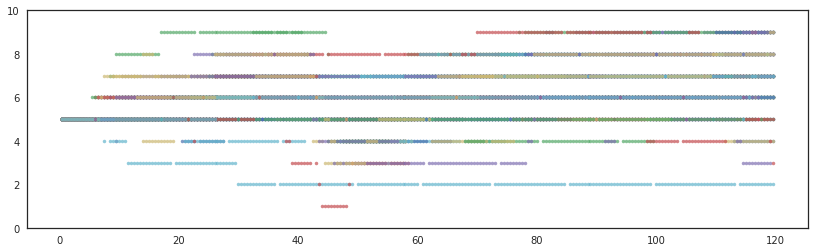

In [31]:
x = all_video_data['second']
y = all_video_data.drop(['second'], axis=1)
plt.figure(figsize=(14,4))
plt.ylim(0,10)
plt.plot(x, y, '.', alpha=0.7);




In [ ]:
BEQ  = pd.read_csv('/data/behavioraldata/BEQ.csv')



BEQ = BEQ.merge(pd.DataFrame(z_correlations, columns=['videoNumber', 'z_corr']))

sns.lmplot('BEQ_total', 'z_corr', data=BEQ)

#sns.distplot(BEQ['z_corr'], bins=10)

In [ ]:
import networkx as nx

def corr_to_distance(x):
    return 1-abs(x)


unique_sub_ids = list(all_video_data)
combinations = pd.DataFrame(list(itertools.combinations(unique_sub_ids, 2)))
corr = all_video_data.corr()

df = []
for index, row in combinations.iterrows():
    df.append([row[0], row[1], corr[row[0]][row[1]]])


df = pd.DataFrame(df)
df.columns = ['sub1', 'sub2', 'corr']

df['z'] = 0.5*np.log((1+df['corr'])/(1-df['corr']))



G = nx.Graph

for index, row in df.iterrows:
    G.add_edge()

    

In [ ]:
import networkx as nx


def corr_to_distance(x):
    return 1-abs(x)

#all_video_data = all_video_data.drop('second',1)
corr = all_video_data.corr()

corr = corr.dropna(axis = 0, how='all')
corr = corr.dropna(axis = 1, how='all')
corr = corr.applymap(corr_to_distance)
print(corr)

G = nx.from_numpy_matrix(corr.as_matrix())



nx.draw(G)



In [ ]:
x = all_video_data['second']
y = all_video_data.drop(['second'], axis=1)


plt.figure(figsize=(14,4))
plt.plot(x, y);

In [ ]:
import networkx as nx
G = nx.Graph()

df = df.dropna(axis=0, how='any')
df = df[df[2]!=1]

df[2]= df[2].apply(lambda x : 1-abs(x))



for index, row in df.iterrows():
    G.add_edge(row[0], row[1], length=row[2])

plt.hist(df[2])
#nx.draw(G)